In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input


In [ ]:
indian_pines_path="/content/drive/MyDrive/Hyperspectral_Data/Indian_pines.mat"
indian_pines_gt_path="/content/drive/MyDrive/Hyperspectral_Data/Indian_pines_gt.mat"
indian_pines_data = sio.loadmat(indian_pines_path)['indian_pines']
indian_pines_gt = sio.loadmat(indian_pines_gt_path)['indian_pines_gt']

In [ ]:
def normalize_data(raw_data):
    max_value = np.max(raw_data)
    min_value = np.min(raw_data)
    normalized_data = (raw_data - min_value) / (max_value - min_value)
    return normalized_data
def dimension_PCA(data, input_dimension):
    # Reshape the data into a 2D array (samples x features)
    height, width, bands  = data.shape
    flattened_data = data.reshape(height * width, bands)

    # Apply PCA to the flattened data
    pca = PCA(n_components=input_dimension)
    pca.fit(flattened_data)

    # Transform the data back to the original shape
    transformed_data = pca.transform(flattened_data)
    whole_pca = transformed_data.reshape(height, width, input_dimension)

    return whole_pca

indian_pines_normalized = normalize_data(indian_pines_data)
indian_pines_pca = dimension_PCA(indian_pines_normalized, 10)
print(indian_pines_pca.shape)


(145, 145, 10)


#**Indian Pines

In [ ]:
######hedha lgdim


from tensorflow.keras.callbacks import EarlyStopping

# Fonction d'extraction de patches
def extract_patches(data, labels, patch_size=5):
    margin = patch_size // 2
    height, width, bands = data.shape  # <<< Ajouté ici

    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0,0)), mode='constant')
    patches = []
    patch_labels = []
    for i in range(margin, margin + height):
        for j in range(margin, margin + width):
            patch = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            patches.append(patch)
            patch_labels.append(labels[i-margin, j-margin])
    return np.array(patches), np.array(patch_labels)

patch_size = 5
patches, patch_labels = extract_patches(indian_pines_pca, indian_pines_gt, patch_size=patch_size)

# Filtrer les patches ayant un label non nul
valid_indices = patch_labels > 0
patches = patches[valid_indices]
patch_labels = patch_labels[valid_indices] - 1  # Labels commencent à 0

# (Important : PAS de expand_dims pour 2D CNN)
# patches = np.expand_dims(patches, axis=-1)  --> PAS BESOIN

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(patches, patch_labels, test_size=0.2, random_state=42, stratify=patch_labels)

# ====================
# 2. Modèle 2D CNN
# ====================

input_shape = (patch_size, patch_size, 10)

model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ====================
# 3. Entrainement
# ====================

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)

# ====================
# 4. Prédiction sur l'image entière
# ====================

def fast_predict_whole_image_2d(model, data, patch_size=5):
    margin = patch_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0,0)), mode='constant')
    height, width, bands = data.shape
    prediction_map = np.zeros((height, width), dtype=int)

    for i in range(height):
        for j in range(width):
            patch = padded_data[i:i+patch_size, j:j+patch_size, :]
            patch = np.expand_dims(patch, axis=0)  # batch_size = 1
            prediction = model.predict(patch, verbose=0)
            prediction_label = np.argmax(prediction)
            prediction_map[i, j] = prediction_label + 1  # Pour matcher les labels originaux

    return prediction_map

# Prédire toute l'image
prediction_map = fast_predict_whole_image_2d(model, indian_pines_pca, patch_size=patch_size)

# ====================
# 5. Affichage
# ====================

def plot_prediction_and_ground_truth(prediction, ground_truth, title="Prediction vs Ground Truth"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(prediction, cmap='jet')
    axes[0].set_title('Prediction')
    axes[0].axis('off')

    axes[1].imshow(ground_truth, cmap='jet')
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    fig.suptitle(title, fontsize=16)
    plt.show()

plot_prediction_and_ground_truth(prediction_map, indian_pines_gt)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 32)       │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,312 (356.69 KB)

 Trainable params: 91,312 (356.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3960 - loss: 1.9174 - val_accuracy: 0.5639 - val_loss: 1.1323
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5573 - loss: 1.1410 - val_accuracy: 0.6751 - val_loss: 0.8641
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6561 - loss: 0.9144 - val_accuracy: 0.7371 - val_loss: 0.7148
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7179 - loss: 0.7498 - val_accuracy: 0.8151 - val_loss: 0.5402
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7811 - loss: 0.6003 - val_accuracy: 0.8307 - val_loss: 0.4645
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8196 - loss: 0.5111 - val_accuracy: 0.8615 - val_loss: 0.4031
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8434 - loss: 0.4396 - val_accuracy: 0.8639 - val_loss: 0.3610
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8743 - loss: 0.3626 - val_accuracy: 0

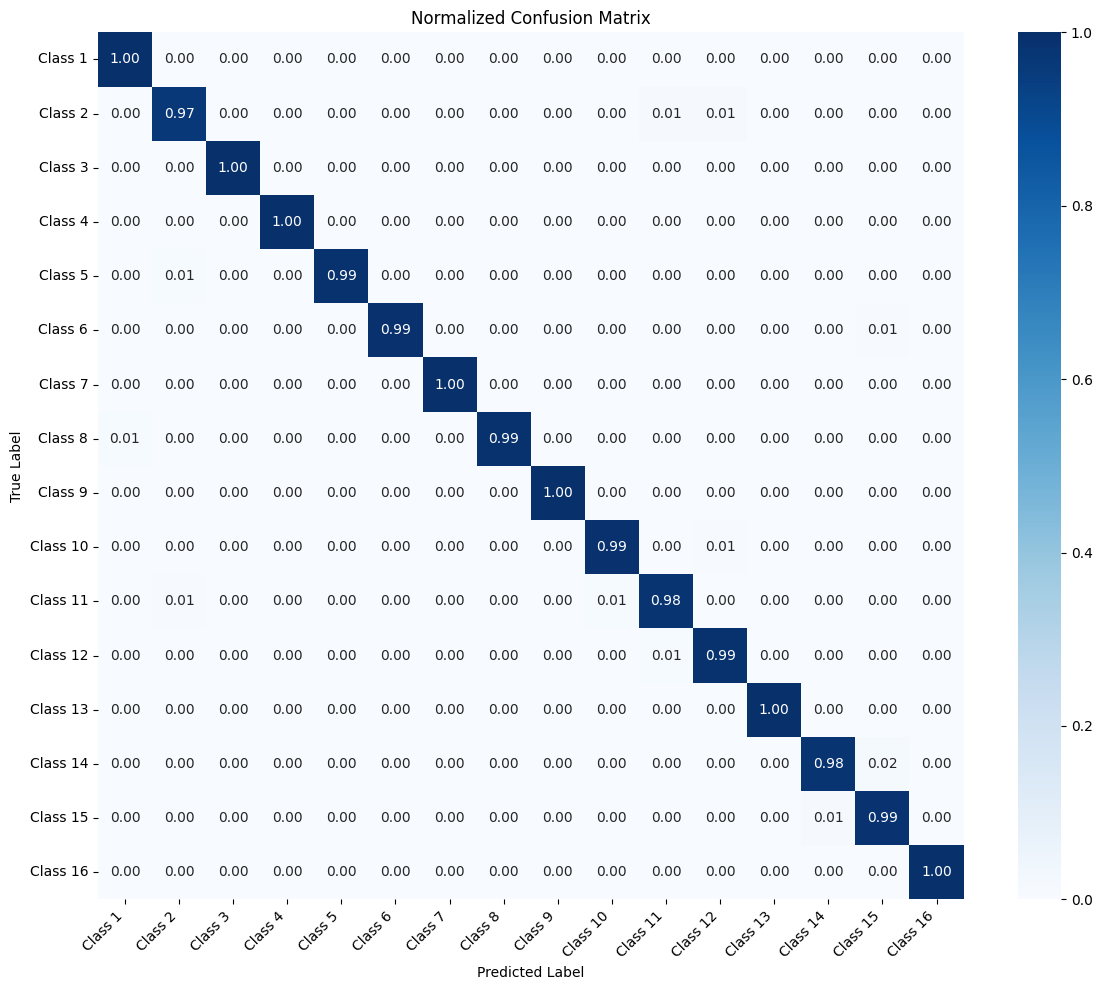

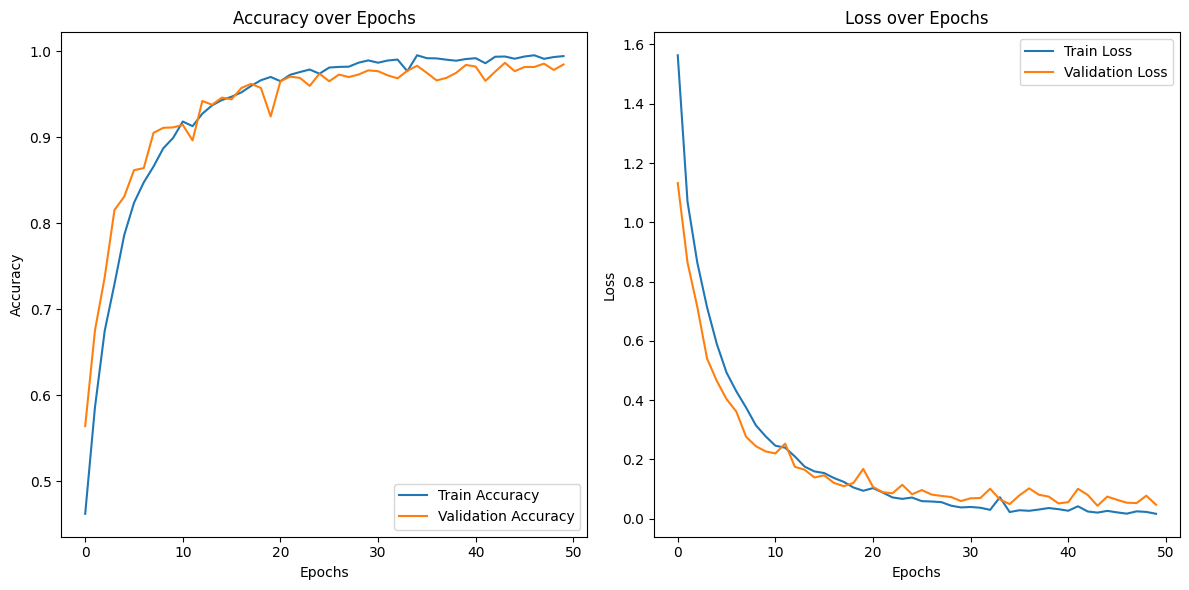

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fonction pour extraire les patchs
def extract_patches(data, labels, patch_size=5):
    margin = patch_size // 2
    height, width, bands = data.shape

    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0,0)), mode='constant')
    patches = []
    patch_labels = []
    for i in range(margin, margin + height):
        for j in range(margin, margin + width):
            patch = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            patches.append(patch)
            patch_labels.append(labels[i-margin, j-margin])
    return np.array(patches), np.array(patch_labels)

# Paramètres
patch_size = 5

# Extraire les patches
patches, patch_labels = extract_patches(indian_pines_pca, indian_pines_gt, patch_size=patch_size)

# Garder seulement les patchs dont le label est > 0 (pixels valides)
valid_indices = patch_labels > 0
patches = patches[valid_indices]
patch_labels = patch_labels[valid_indices] - 1  # Pour commencer à 0

# Séparer en train / test
X_train, X_test, y_train, y_test = train_test_split(
    patches, patch_labels, test_size=0.2, random_state=42, stratify=patch_labels
)

# Créer le modèle 2D CNN
input_shape = (patch_size, patch_size, 10)

model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='softmax')  # 16 classes in the Indian Pines dataset
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Entraîner le modèle
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)

# -----------------------------------------------
# Evaluation on the test set
y_pred = model.predict(X_test, batch_size=64)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred_labels)

# Print classification report (precision, recall, F1-score, etc.)
report = classification_report(y_test, y_pred_labels, target_names=[f"Class {i+1}" for i in range(16)])

print(f"Overall accuracy: {accuracy:.4f}")
print(report)

# -----------------------------------------------

# 1. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# 2. Normalize the confusion matrix (optional but looks even better)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Set up the labels
labels = [f"Class {i+1}" for i in range(16)]

# 4. Plot it
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=labels, yticklabels=labels, cbar=True)

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: Display training history (loss and accuracy)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


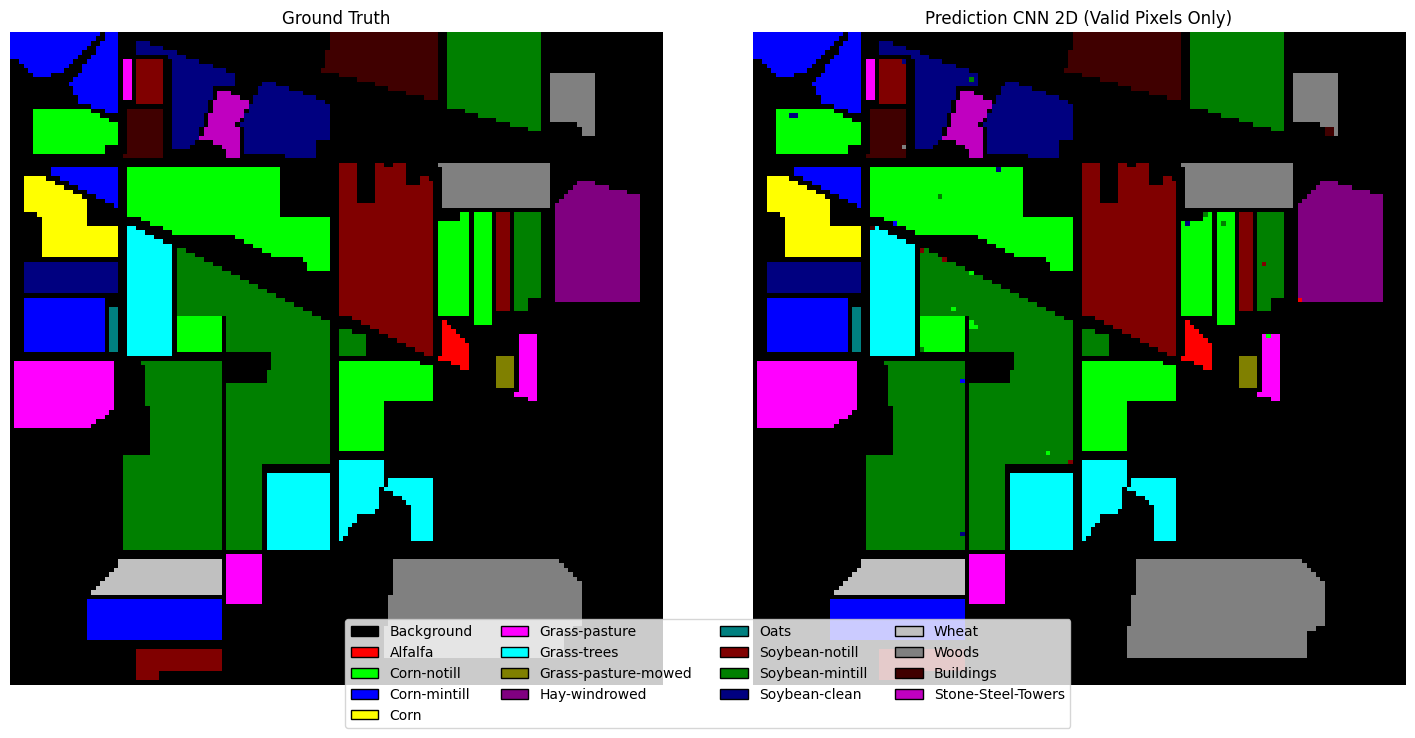

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Fonction rapide pour prédire sur l'image entière, uniquement pour les pixels valides
def fast_predict_whole_image_2d(model, data, gt_data, patch_size=5):
    margin = patch_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    height, width, bands = data.shape
    padded_gt = np.pad(gt_data, ((margin, margin), (margin, margin)), mode='constant')

    patches = []
    valid_positions = []

    # Collect patches only for valid (non-background) pixels
    for i in range(height):
        for j in range(width):
            if padded_gt[i + margin, j + margin] != 0:  # Check if it's not a background pixel
                patch = padded_data[i:i+patch_size, j:j+patch_size, :]
                patches.append(patch)
                valid_positions.append((i, j))

    patches = np.array(patches)  # Shape: (valid_pixels_count, patch_size, patch_size, bands)

    # Predict all valid patches at once
    predictions = model.predict(patches, batch_size=128, verbose=1)  # Adjust batch_size if needed
    predicted_labels = np.argmax(predictions, axis=1) + 1  # To match ground truth labels

    # Reconstruct the full prediction map
    prediction_map = np.zeros((height, width), dtype=np.uint8)  # Initialize with background (0)
    for idx, (i, j) in enumerate(valid_positions):
        prediction_map[i, j] = predicted_labels[idx]

    return prediction_map


# -----------------------------------------------
# Color palette for Indian Pines

palette_indian_pines = {
    0: (0, 0, 0),         # Background - Black
    1: (255, 0, 0),       # Alfalfa - Red
    2: (0, 255, 0),       # Corn-notill - Green
    3: (0, 0, 255),       # Corn-mintill - Blue
    4: (255, 255, 0),     # Corn - Yellow
    5: (255, 0, 255),     # Grass-pasture - Magenta
    6: (0, 255, 255),     # Grass-trees - Cyan
    7: (128, 128, 0),     # Grass-pasture-mowed - Olive
    8: (128, 0, 128),     # Hay-windrowed - Violet
    9: (0, 128, 128),     # Oats - Turquoise
    10: (128, 0, 0),      # Soybean-notill - Maroon
    11: (0, 128, 0),      # Soybean-mintill - Dark Green
    12: (0, 0, 128),      # Soybean-clean - Dark Blue
    13: (192, 192, 192),  # Wheat - Light Gray
    14: (128, 128, 128),  # Woods - Gray
    15: (64, 0, 0),       # Buildings - Dark Brown
    16: (192, 0, 192)     # Stone-Steel-Towers - Light Violet
}

indian_pines_names_class = {
    0: "Background",
    1: "Alfalfa",
    2: "Corn-notill",
    3: "Corn-mintill",
    4: "Corn",
    5: "Grass-pasture",
    6: "Grass-trees",
    7: "Grass-pasture-mowed",
    8: "Hay-windrowed",
    9: "Oats",
    10: "Soybean-notill",
    11: "Soybean-mintill",
    12: "Soybean-clean",
    13: "Wheat",
    14: "Woods",
    15: "Buildings",
    16: "Stone-Steel-Towers"
}

# -----------------------------------------------
# Apply palette function
def apply_palette(label_map, palette):
    rgb_image = np.zeros((label_map.shape[0], label_map.shape[1], 3), dtype=np.uint8)
    for label, color in palette.items():
        rgb_image[label_map == label] = color
    return rgb_image

# -----------------------------------------------
# Perform prediction on the entire image using the model
patch_size = 5  # or whatever patch size you used
prediction_map = fast_predict_whole_image_2d(model, indian_pines_pca, indian_pines_gt, patch_size)

# -----------------------------------------------
# Create RGB images for visualization
ground_truth_rgb = apply_palette(indian_pines_gt, palette_indian_pines)
prediction_rgb = apply_palette(prediction_map, palette_indian_pines)

# -----------------------------------------------
# Display results

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Ground truth on the left
axs[0].imshow(ground_truth_rgb)
axs[0].set_title('Ground Truth')
axs[0].axis('off')

# Prediction on the right
axs[1].imshow(prediction_rgb)
axs[1].set_title('Prediction CNN 2D (Valid Pixels Only)')
axs[1].axis('off')

# Legend
legend_elements = [
    Patch(facecolor=np.array(color)/255, edgecolor='k', label=indian_pines_names_class[label])
    for label, color in palette_indian_pines.items()
]

fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()


# Pavia University


In [ ]:
pavia_university_path = "/content/drive/MyDrive/Hyperspectral_Data/PaviaU.mat"
pavia_university_gt_path = "/content/drive/MyDrive/Hyperspectral_Data/PaviaU_gt.mat"
PaviaU_data = sio.loadmat(pavia_university_path)['paviaU']
PaviaU_gt = sio.loadmat(pavia_university_gt_path)['paviaU_gt']

In [ ]:
###functions defined above (same as indian pines')
pavia_normalized = normalize_data(PaviaU_data)
pavia_pca = dimension_PCA(pavia_normalized, 3)
print(pavia_pca.shape)

(610, 340, 3)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 5, 5, 32)       │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,497 (341.79 KB)

 Trainable params: 87,497 (341.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7489 - loss: 0.7619 - val_accuracy: 0.8806 - val_loss: 0.2949
Epoch 2/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8804 - loss: 0.2946 - val_accuracy: 0.9022 - val_loss: 0.2375
Epoch 3/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8982 - loss: 0.2474 - val_accuracy: 0.9183 - val_loss: 0.2098
Epoch 4/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9145 - loss: 0.2124 - val_accuracy: 0.9119 - val_loss: 0.2014
Epoch 5/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9235 - loss: 0.1903 - val_accuracy: 0.9201 - val_loss: 0.1999
Epoch 6/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9299 - loss: 0.1708 - val_accuracy: 0.9369 - val_loss: 0.1600
Epoch 7/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9374 - loss: 0.1611 - val_accuracy: 0.9372 - val_loss: 0.1582
Epoch 8/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9427 - loss: 0.1481 - val_accuracy: 0.

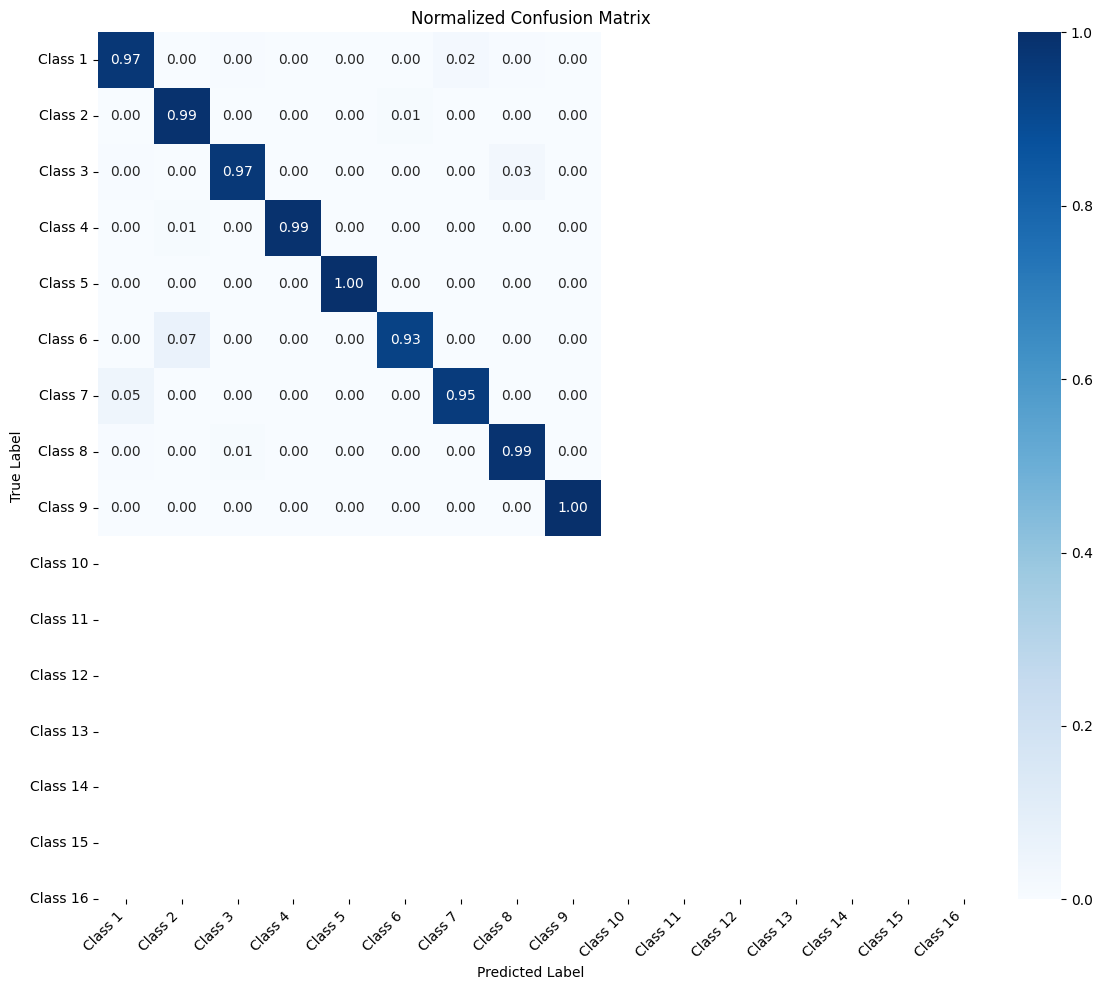

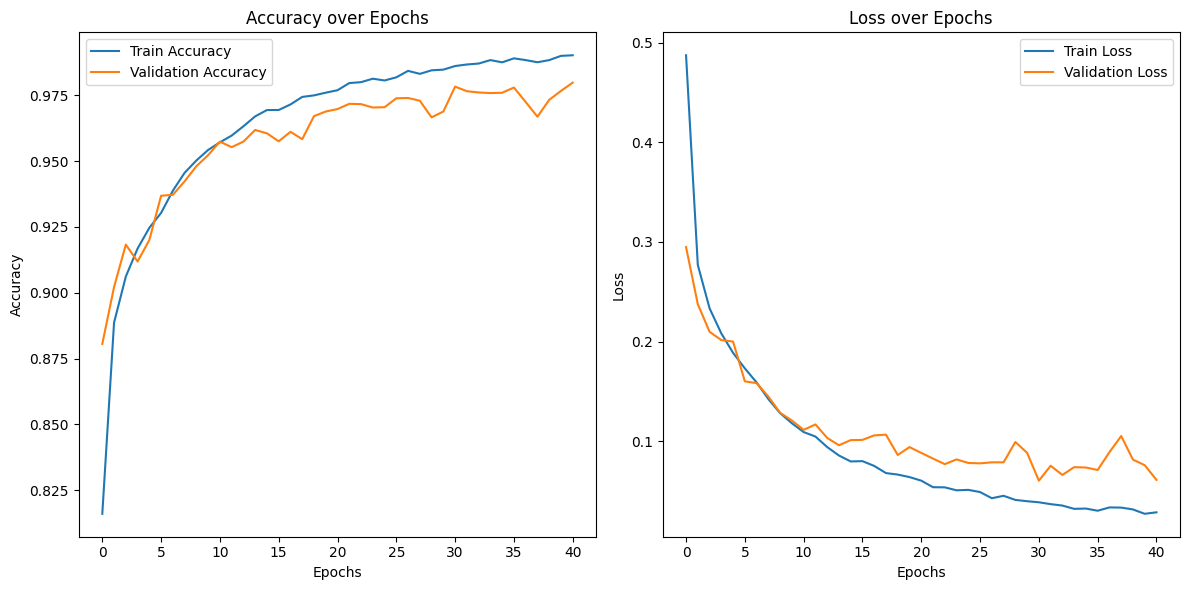

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Fonction pour extraire les patchs
def extract_patches(data, labels, patch_size=5):
    margin = patch_size // 2
    height, width, bands = data.shape

    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    patches = []
    patch_labels = []
    for i in range(margin, margin + height):
        for j in range(margin, margin + width):
            patch = padded_data[i - margin:i + margin + 1, j - margin:j + margin + 1, :]
            patches.append(patch)
            patch_labels.append(labels[i - margin, j - margin])
    return np.array(patches), np.array(patch_labels)

# Paramètres
patch_size = 5


# Extraire les patches
patches, patch_labels = extract_patches(pavia_pca, PaviaU_gt, patch_size=patch_size)

# Garder seulement les patchs dont le label est > 0 (pixels valides)
valid_indices = patch_labels > 0
patches = patches[valid_indices]
patch_labels = patch_labels[valid_indices] - 1  # Pour commencer à 0

# Séparer en train / test
X_train, X_test, y_train, y_test = train_test_split(
    patches, patch_labels, test_size=0.2, random_state=42, stratify=patch_labels
)

# Créer le modèle 2D CNN
input_shape = (patch_size, patch_size, 3)  # Pavia University has 3 PCA components

model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')  # 9 classes in the Pavia University dataset
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Entraîner le modèle
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)

# -----------------------------------------------
# Evaluation on the test set
y_pred = model.predict(X_test, batch_size=64)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred_labels)

# Print classification report (precision, recall, F1-score, etc.)
report = classification_report(y_test, y_pred_labels, target_names=[f"Class {i+1}" for i in range(9)])

print(f"Overall accuracy: {accuracy:.4f}")
print(report)

# -----------------------------------------------
# Optional: Display training history (loss and accuracy)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


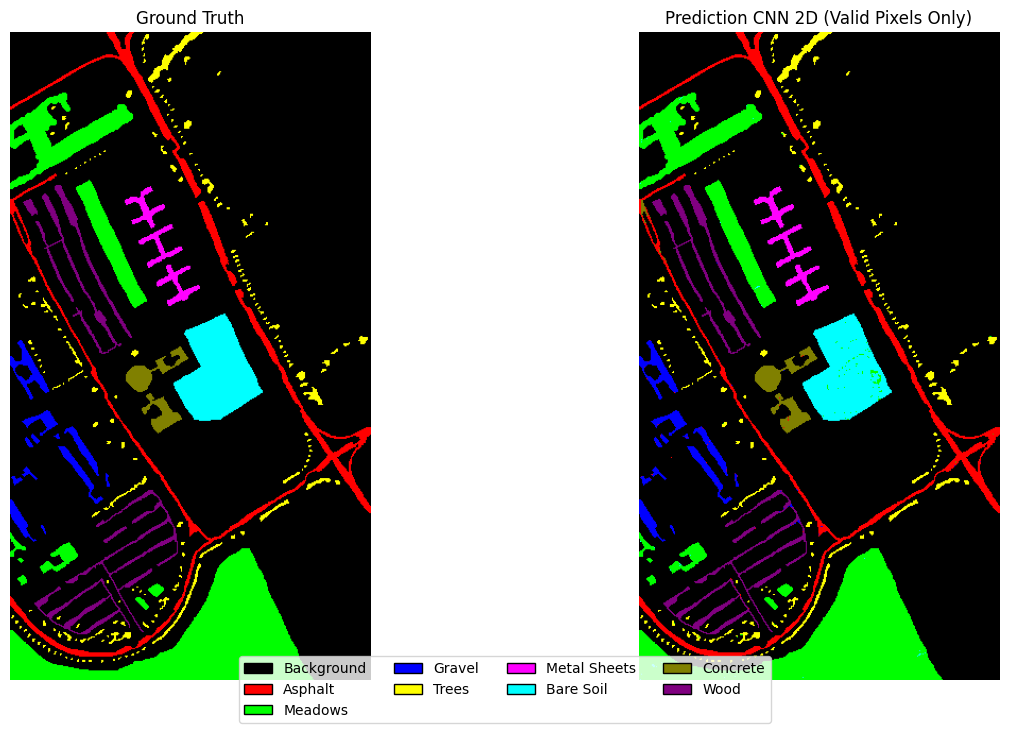

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Fonction rapide pour prédire sur l'image entière, uniquement pour les pixels valides
def fast_predict_whole_image_2d(model, data, gt_data, patch_size=5):
    margin = patch_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    height, width, bands = data.shape
    padded_gt = np.pad(gt_data, ((margin, margin), (margin, margin)), mode='constant')

    patches = []
    valid_positions = []

    # Collect patches only for valid (non-background) pixels
    for i in range(height):
        for j in range(width):
            if padded_gt[i + margin, j + margin] != 0:  # Check if it's not a background pixel
                patch = padded_data[i:i+patch_size, j:j+patch_size, :]
                patches.append(patch)
                valid_positions.append((i, j))

    patches = np.array(patches)  # Shape: (valid_pixels_count, patch_size, patch_size, bands)

    # Predict all valid patches at once
    predictions = model.predict(patches, batch_size=128, verbose=1)  # Adjust batch_size if needed
    predicted_labels = np.argmax(predictions, axis=1) + 1  # To match ground truth labels

    # Reconstruct the full prediction map
    prediction_map = np.zeros((height, width), dtype=np.uint8)  # Initialize with background (0)
    for idx, (i, j) in enumerate(valid_positions):
        prediction_map[i, j] = predicted_labels[idx]

    return prediction_map


# -----------------------------------------------
# Color palette for Pavia University (9 classes)

palette_pavia = {
    0: (0, 0, 0),         # Background - Black
    1: (255, 0, 0),       # Asphalt - Red
    2: (0, 255, 0),       # Meadows - Green
    3: (0, 0, 255),       # Gravel - Blue
    4: (255, 255, 0),     # Trees - Yellow
    5: (255, 0, 255),     # Metal Sheets - Magenta
    6: (0, 255, 255),     # Bare Soil - Cyan
    7: (128, 128, 0),     # Concrete - Olive
    8: (128, 0, 128)      # Wood - Violet
}

pavia_names_class = {
    0: "Background",
    1: "Asphalt",
    2: "Meadows",
    3: "Gravel",
    4: "Trees",
    5: "Metal Sheets",
    6: "Bare Soil",
    7: "Concrete",
    8: "Wood"
}

# -----------------------------------------------
# Apply palette function
def apply_palette(label_map, palette):
    rgb_image = np.zeros((label_map.shape[0], label_map.shape[1], 3), dtype=np.uint8)
    for label, color in palette.items():
        rgb_image[label_map == label] = color
    return rgb_image

# -----------------------------------------------
# Perform prediction on the entire image using the model
patch_size = 5  # or whatever patch size you used
prediction_map = fast_predict_whole_image_2d(model, pavia_pca, PaviaU_gt, patch_size)

# -----------------------------------------------
# Create RGB images for visualization
ground_truth_rgb = apply_palette(PaviaU_gt, palette_pavia)
prediction_rgb = apply_palette(prediction_map, palette_pavia)

# -----------------------------------------------
# Display results

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Ground truth on the left
axs[0].imshow(ground_truth_rgb)
axs[0].set_title('Ground Truth')
axs[0].axis('off')

# Prediction on the right
axs[1].imshow(prediction_rgb)
axs[1].set_title('Prediction CNN 2D (Valid Pixels Only)')
axs[1].axis('off')

# Legend
legend_elements = [
    Patch(facecolor=np.array(color)/255, edgecolor='k', label=pavia_names_class[label])
    for label, color in palette_pavia.items()
]

fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()
